**Importations**

In [2]:
import kagglehub
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import random
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

c:\Users\gbert\miniconda3\envs\env_conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Téléchargement du jeu de données**

In [3]:
path = kagglehub.dataset_download("asinow/car-price-dataset")
file_path = os.path.join(path, 'car_price_dataset.csv')
print(f"Le jeu de données à été installé au chemin d'accès suivant : {path}")

Le jeu de données à été installé au chemin d'accès suivant : C:\Users\gbert\.cache\kagglehub\datasets\asinow\car-price-dataset\versions\1


**Création du dataframe et visualisation des données**

In [4]:
df = pd.read_csv(file_path, encoding='utf-8')

print("\033[1;31m---- Head ----\033[0m")
print(df.head())
print("\033[1;31m---- Info ----\033[0m")
print(df.info())

---- Head ----
        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867  
---- Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-

**Vérification du nombres de catégories pour chaque colonnes de type object**

En effet, je souhaite utiliser le one hot encoding car il évite le biais relationnel à l'inverse du LabelEncoding mais il est coûteux si le nombre de catégories est trop élevé

In [5]:
print("\033[1;31m---- Statistiques ----\033[0m")
for column in ["Brand", "Model", "Transmission", "Fuel_Type"]:
    num_unique = df[column].nunique()
    print(f"Nombre de {column} différents : {num_unique}")

---- Statistiques ----
Nombre de Brand différents : 10
Nombre de Model différents : 30
Nombre de Transmission différents : 3
Nombre de Fuel_Type différents : 4


**Préparation des splits de données**

In [7]:
# Séparer les features et la cible
X = df.drop(columns=["Price"])
y = df["Price"]

# Diviser en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifier les colonnes catégorielles et numériques
cat_columns = ["Brand", "Model", "Transmission", "Fuel_Type"]
num_columns = ["Year", "Engine_Size", "Mileage", "Doors", "Owner_Count"]

# Définir le préprocesseur
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_columns),
    ("scaler", StandardScaler(), num_columns)
])

# Appliquer la transformation sur les données d'entraînement et de test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(f"Taille de l'ensemble d'entraînement après transformation : {X_train.shape}")
print(f"Taille de l'ensemble de test après transformation : {X_test.shape}")


Taille de l'ensemble d'entraînement après transformation : (8000, 52)
Taille de l'ensemble de test après transformation : (2000, 52)


**Définition du model**

In [8]:
model = Sequential([ Dense(units=52, activation="relu", input_shape=(X_train.shape[1],)),
                   Dense(units=30, activation="relu"),
                    Dense(units=15, activation="relu"),
                    Dense(units=5, activation="relu"),
                     Dense(units=1)
                ])

model.summary()

c:\Users\gbert\miniconda3\envs\env_conda\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 52)             │         2,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,590 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

**Entrainement du model**

In [9]:
optimizer = Adam(learning_rate=0.1)                                                                                     # Définir l'optimiseur avec lr=0.1 au début
model.compile(loss="mse", optimizer=optimizer)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=0.001)                      # - Divise le learning rate par 10 à chaque fois que le modèle ne s'ameliore pas en 3 epoch
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)                        # - EarlyStopping stoppe l'entraînement et garde le meilleur modèle           
h = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stop])         

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13017837.0000 - val_loss: 5485.5220 - learning_rate: 0.1000
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5061.6587 - val_loss: 2219.3337 - learning_rate: 0.1000
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2679.5698 - val_loss: 1320.5464 - learning_rate: 0.1000
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1764.5303 - val_loss: 3069.0889 - learning_rate: 0.1000
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10410.2373 - val_loss: 89153.3594 - learning_rate: 0.1000
Epoch 6/50
191/250 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 49191.7031
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46584.3047 - val_loss: 68104.4062 - learning_rate: 0.1000
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7887.1055 - val_loss: 266.6331 - learning_rate: 0.0100
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1

**Visualisation de l'évolution de la loss et val-loss**

In [10]:
def plot_learning_curve(history):


  plt.plot(list(range(len(history['loss']))), history['loss'])
  plt.plot(list(range(len(history['val_loss']))), history['val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.title("Learning Curve")
  plt.show()

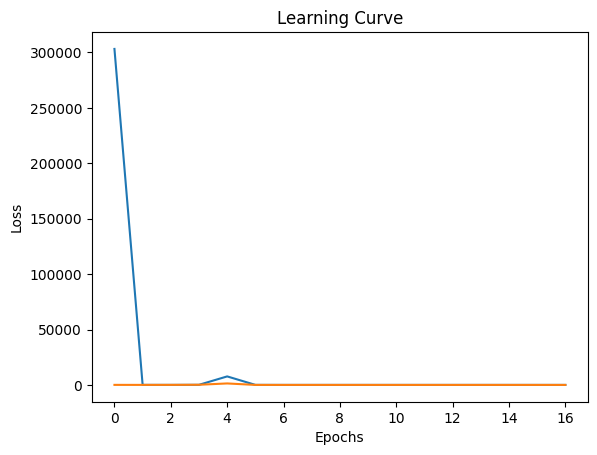

In [30]:
plot_learning_curve(h.history)

**Test du model sur 5 voitures**

In [11]:
indices = random.sample(range(X_test.shape[0]), 5)

X_sample = X_test[indices]  
y_real = y_test.iloc[indices]


y_pred = model.predict(X_sample).flatten()      

results = []
for i in range(len(indices)):
    difference = abs(y_real.values[i] - y_pred[i])
    results.append([indices[i], y_real.values[i], round(y_pred[i], 2), round(difference, 2)])

headers = ["Index", "Prix Réel (€)", "Prix Prédit (€)", "Différence (€)"]
print(tabulate(results, headers=headers, tablefmt="fancy_grid"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
╒═════════╤═════════════════╤═══════════════════╤══════════════════╕
│   Index │   Prix Réel (€) │   Prix Prédit (€) │   Différence (€) │
╞═════════╪═════════════════╪═══════════════════╪══════════════════╡
│     703 │            9449 │           9447.03 │             1.97 │
├─────────┼─────────────────┼───────────────────┼──────────────────┤
│    1327 │           10738 │          10733.6  │             4.4  │
├─────────┼─────────────────┼───────────────────┼──────────────────┤
│     388 │           13792 │          13792.9  │             0.92 │
├─────────┼─────────────────┼───────────────────┼──────────────────┤
│    1086 │           13588 │          13589.4  │             1.35 │
├─────────┼─────────────────┼───────────────────┼──────────────────┤
│     237 │           10308 │          10306.7  │             1.33 │
╘═════════╧═════════════════╧═══════════════════╧══════════════════╛


**Visualisation de l'impact des différentes caractéristiques sur le prix**

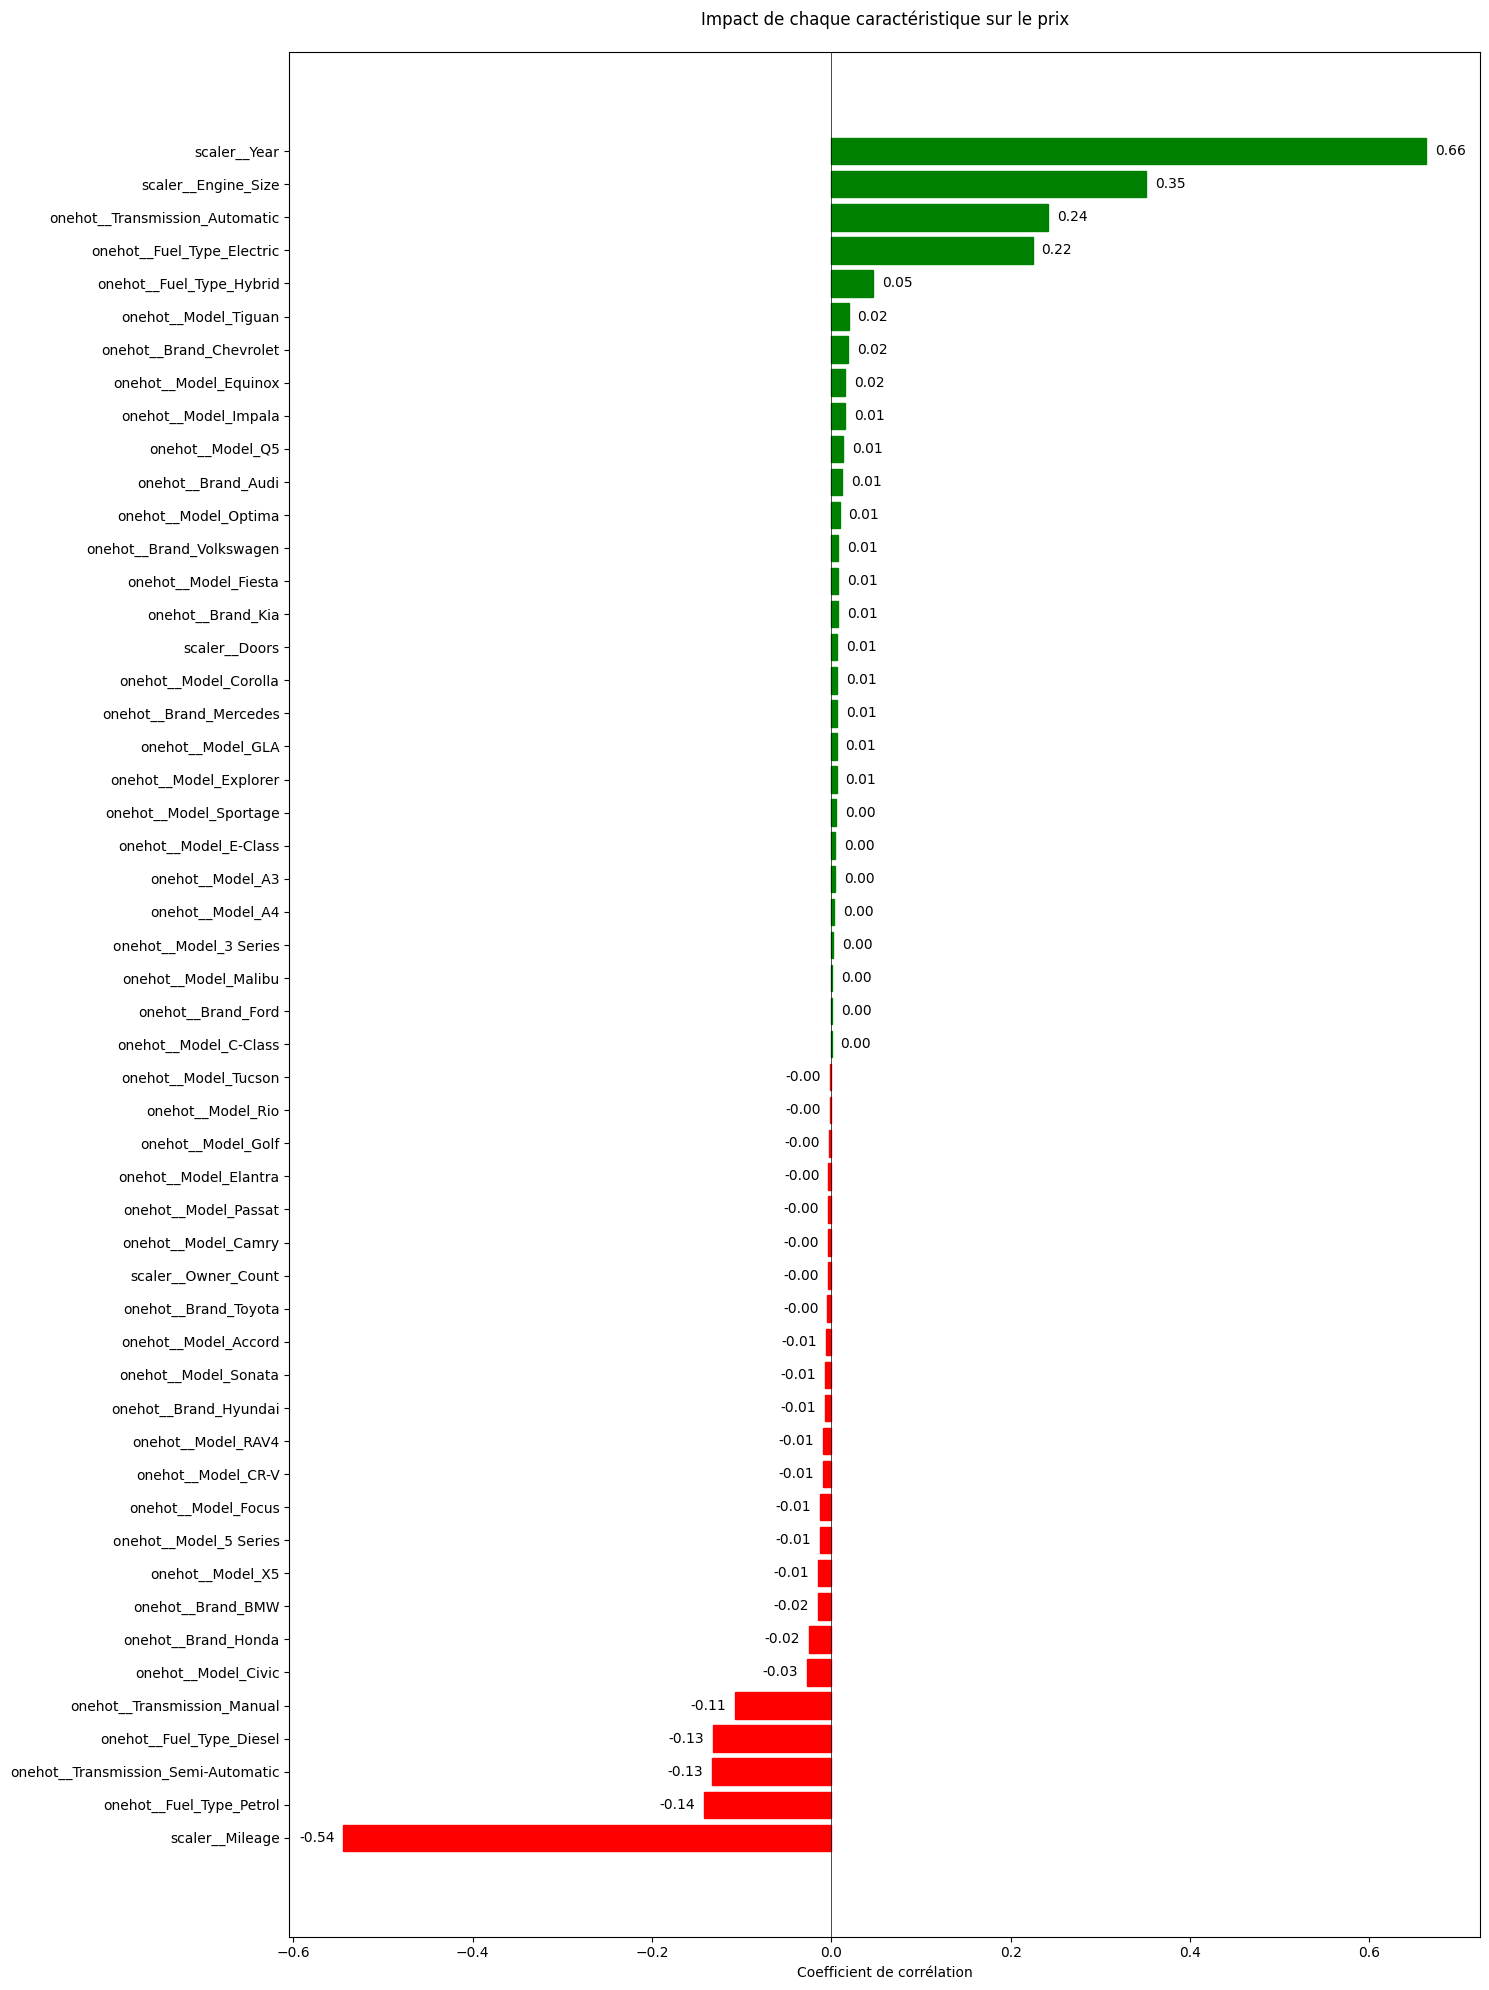

In [12]:
X_train_dense = X_train.toarray()
feature_names = preprocessor.get_feature_names_out()

# Calculer la corrélation entre chaque feature et le prix
correlations = []
for i, feature in enumerate(feature_names):
    correlation, _ = spearmanr(X_train_dense[:, i], y_train)
    correlations.append({
        'Feature': feature,
        'Impact': correlation
    })

# Créer un DataFrame avec les corrélations
impact_df = pd.DataFrame(correlations)
impact_df = impact_df.sort_values('Impact', ascending=True)

# Créer le graphique
plt.figure(figsize=(15, 20))
bars = plt.barh(impact_df['Feature'], impact_df['Impact'])

for bar in bars:
    if bar.get_width() < 0:
        bar.set_color('red')
    else:
        bar.set_color('green')

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title('Impact de chaque caractéristique sur le prix', pad=20)
plt.xlabel('Coefficient de corrélation')

# Ajouter les valeurs sur les barres
for i, v in enumerate(impact_df['Impact']):
    plt.text(v + (0.01 if v >= 0 else -0.01), 
             i,
             f'{v:.2f}',
             va='center',
             ha='left' if v >= 0 else 'right')

plt.tight_layout()
plt.show()

**Sauvegarde et chargement du model**

In [66]:
model.save('model.keras')
new_model = load_model('model.keras')
new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 52)             │         2,756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 30)             │         1,590 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,693 (57.40 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,796 (38.27 KB)